[Taichi] version 1.7.2, llvm 15.0.7, commit 0131dce9, osx, python 3.9.6


[I 03/24/25 14:59:05.664 23844649] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=arm64
results = {'Threads=1, Block=1': [], 'Threads=8, Block=16': [], 'Threads=8, Block=32': [], 'Threads=16, Block=64': [], 'Dense Memory': [], 'Pointer Memory': [], 'Vector Memory': [], 'NumPy': []}
Testing with 10 particles
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
Testing with 100 particles
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
Testing with 500 particles
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
[Taichi] Starting on arch=arm64
Testing with 1000 par

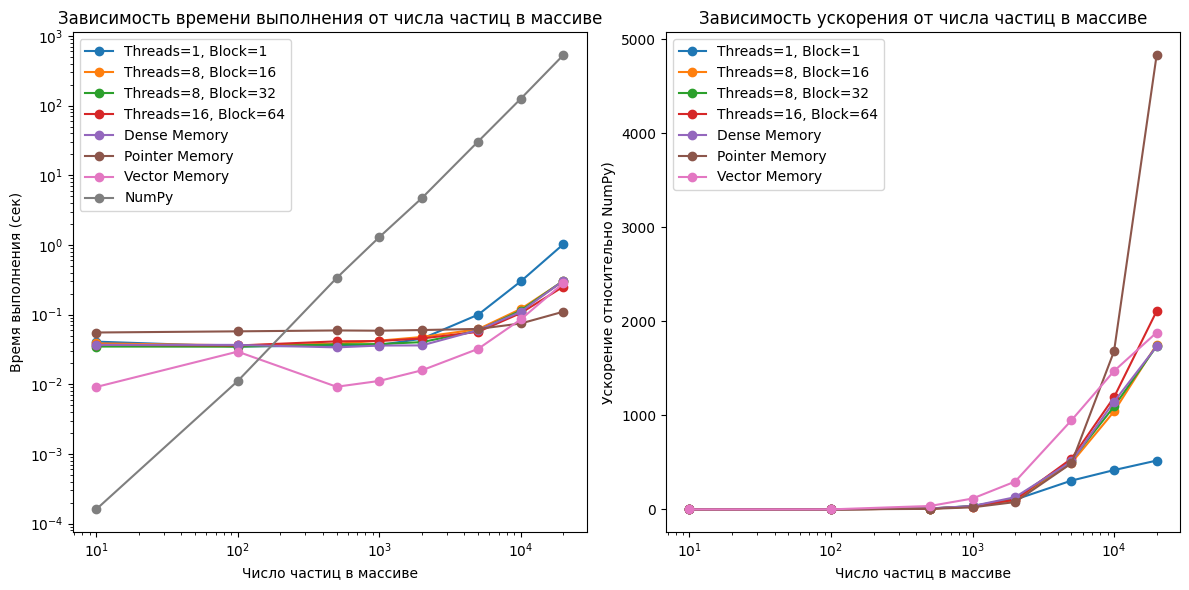

In [1]:
import taichi as ti
import numpy as np
import time
import matplotlib.pyplot as plt

# Инициализация Taichi
ti.init(arch=ti.cpu)

# Размеры массивов для тестирования
particle_counts = [10, 100, 500, 10**3, 2 * 10**3, 5 * 10**3, 10**4, 2 * 10**4]

# Настройки Taichi для тестирования
threads_blocks_managment_settings = [
    {"cpu_max_num_threads": 1, "block_size": 1, "label": "Threads=1, Block=1"},
    {"cpu_max_num_threads": 8, "block_size": 16, "label": "Threads=8, Block=16"},
    {"cpu_max_num_threads": 8, "block_size": 32, "label": "Threads=8, Block=32"},
    {"cpu_max_num_threads": 16, "block_size": 64, "label": "Threads=16, Block=64"},
]

memory_management_settings = [
    {"cpu_max_num_threads": 8, "memory_layout": "dense", "label": "Dense Memory"},
    {"cpu_max_num_threads": 8, "memory_layout": "pointer", "label": "Pointer Memory"},
    {"cpu_max_num_threads": 8, "memory_layout": "vector", "label": "Vector Memory"},
]

# Функция для вычисления сил в Taichi
def compute_taichi_threads_blocks_managment(n, cpu_max_num_threads, block_size):
    ti.init(arch=ti.cpu, cpu_max_num_threads=cpu_max_num_threads)
    
    # Организация данных через плотные массивы с заданным размером блока
    grid_size = (n + block_size - 1) // block_size  # Вычисление размера сетки
    positions = ti.Vector.field(3, dtype=ti.f32)
    forces = ti.Vector.field(3, dtype=ti.f32)
    ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(positions)
    ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(forces)
    
    @ti.kernel
    def compute_forces():
        for i in range(n):
            for j in range(i + 1, n):
                diff = positions[j] - positions[i]
                dist = diff.norm()
                if dist > 1e-5:  # Избегаем деления на ноль
                    force = diff / dist**3
                    forces[i] += force
                    forces[j] -= force
    
    # Заполнение массива случайными значениями
    positions.from_numpy(np.random.rand(n, 3).astype(np.float32))
    
    # Замер времени выполнения
    start_time = time.time()
    compute_forces()
    end_time = time.time()
    
    return end_time - start_time

# Функция для вычисления сил в NumPy
def compute_numpy(n):
    positions = np.random.rand(n, 3).astype(np.float32)
    forces = np.zeros((n, 3), dtype=np.float32)
    
    # Замер времени выполнения
    start_time = time.time()
    for i in range(n):
        for j in range(i + 1, n):
            diff = positions[j] - positions[i]
            dist = np.linalg.norm(diff)
            if dist > 1e-5:  # Избегаем деления на ноль
                force = diff / dist**3
                forces[i] += force
                forces[j] -= force
    end_time = time.time()
    
    return end_time - start_time


# Функция для вычисления сил в Taichi
def compute_taichi_memory_management(n, cpu_max_num_threads, memory_layout):
    ti.init(arch=ti.cpu, cpu_max_num_threads=cpu_max_num_threads)
    
    if memory_layout == "dense":
        # Плотные массивы
        positions = ti.Vector.field(3, dtype=ti.f32, shape=n)
        forces = ti.Vector.field(3, dtype=ti.f32, shape=n)
    elif memory_layout == "pointer":
        # Разреженные массивы
        block_size = 16
        grid_size = (n + block_size - 1) // block_size  # Вычисление размера сетки
        positions = ti.Vector.field(3, dtype=ti.f32)
        forces = ti.Vector.field(3, dtype=ti.f32)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(positions)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(forces)
    elif memory_layout == "vector":
        # Использование ti.Vector
        positions = ti.Vector.field(3, dtype=ti.f32, shape=n)
        forces = ti.Vector.field(3, dtype=ti.f32, shape=n)
    
    @ti.kernel
    def compute_forces():
        for i in range(n):
            for j in range(i + 1, n):
                diff = positions[j] - positions[i]
                dist = diff.norm()
                if dist > 1e-5:  # Избегаем деления на ноль
                    force = diff / dist**3
                    forces[i] += force
                    forces[j] -= force
    
    # Заполнение массива случайными значениями
    positions.from_numpy(np.random.rand(n, 3).astype(np.float32))
    
    # Замер времени выполнения
    start_time = time.time()
    compute_forces()
    end_time = time.time()
    
    return end_time - start_time

# Сбор данных для графиков
settings = threads_blocks_managment_settings+memory_management_settings
results = {setting["label"]: [] for setting in settings}
results["NumPy"] = []

print(f"{results = }")

for n in particle_counts:
    print(f"Testing with {n} particles")
    
    # Тестирование NumPy
    numpy_time = compute_numpy(n)
    results["NumPy"].append(numpy_time)
    
    # Тестирование Taichi для всех настроек многопоточности
    for setting in threads_blocks_managment_settings:
        taichi_time = compute_taichi_threads_blocks_managment(
            n,
            cpu_max_num_threads=setting["cpu_max_num_threads"],
            block_size=setting["block_size"]
        )
        results[setting["label"]].append(taichi_time)

    # Тестирование Taichi для всех настроек использования памяти
    for setting in memory_management_settings:
        taichi_time = compute_taichi_memory_management(
            n,
            cpu_max_num_threads=setting["cpu_max_num_threads"],
            memory_layout=setting["memory_layout"]
        )
        results[setting["label"]].append(taichi_time)


# Построение графиков
plt.figure(figsize=(12, 6))

# График времени выполнения
plt.subplot(1, 2, 1)
for label, times in results.items():
    plt.plot(particle_counts, times, label=label, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
plt.title("Зависимость времени выполнения от числа частиц в массиве")
plt.legend()

# График ускорения относительно NumPy
plt.subplot(1, 2, 2)
for label, times in results.items():
    if label != "NumPy":
        speedup = [numpy_t / t for numpy_t, t in zip(results["NumPy"], times)]
        plt.plot(particle_counts, speedup, label=label, marker='o')
plt.xscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Ускорение относительно NumPy)")
plt.title("Зависимость ускорения от числа частиц в массиве")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import taichi as ti
import numpy as np
import time
import matplotlib.pyplot as plt

# Инициализация Taichi
ti.init(arch=ti.cpu)

# Размеры массивов для тестирования
particle_counts = [10, 100, 500, 10 ** 3, 2 * 10 ** 3, 5 * 10 ** 3, 10 ** 4, 2 * 10 ** 4]

# Настройки Taichi для тестирования
threads_blocks_managment_settings = [
    {"cpu_max_num_threads": 1, "block_size": 1, "label": "Threads=1, Block=1"},
    {"cpu_max_num_threads": 8, "block_size": 16, "label": "Threads=8, Block=16"},
    {"cpu_max_num_threads": 8, "block_size": 32, "label": "Threads=8, Block=32"},
    {"cpu_max_num_threads": 16, "block_size": 64, "label": "Threads=16, Block=64"},
]

memory_management_settings = [
    {"cpu_max_num_threads": 8, "memory_layout": "dense", "label": "Dense Memory"},
    {"cpu_max_num_threads": 8, "memory_layout": "pointer", "label": "Pointer Memory"},
    {"cpu_max_num_threads": 8, "memory_layout": "vector", "label": "Vector Memory"},
]

B = 0
C = 100
Cs = 1000
d = 1.25
m = 0.1
t = 3.0
g = 9.81
x0 = 0.5
dt = 1E-5
nstep = int(t / dt)


# Функция для вычисления сил в Taichi
def compute_taichi_threads_blocks_managment(n, cpu_max_num_threads, block_size):
    ti.reset()
    ti.init(arch=ti.cpu, cpu_max_num_threads=cpu_max_num_threads)

    # Организация данных через плотные массивы с заданным размером блока
    grid_size = (n + block_size - 1) // block_size  # Вычисление размера сетки

    print(grid_size)
    x = ti.Vector.field(3, dtype=ti.f32)
    v = ti.Vector.field(3, dtype=ti.f32)

    ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(x)
    ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(v)

    dx = ti.Vector.field(3, dtype=ti.f32)
    ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(dx)
    F = ti.Vector.field(3, dtype=ti.f32)
    ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(F)


    l = d / n

    @ti.kernel
    def Init():
        for i in range(n):
            x[i] = [0, l * i + x0, 0]
            v[i] = [0, 0, 0]
            # x2[i] = [0, l * i + x0, 0]
            # v2[i] = [0, 0, 0]

    @ti.kernel
    def substep():
        for j in range(n - 1):
            dx[j] = x[j + 1] - x[j] - ti.Vector([0, l, 0])

        for j in range(n):
            left = -C * dx[j - 1] if j > 0 else 0.0
            right = C * dx[j] if j < n - 1 else 0.0
            contact = -Cs * x[j] if j == 0 and x[j][1] < 0.0 else 0.0
            F[j] = left + right - B * v[j] + contact - m * ti.Vector([0, 9.8, 0])

        for j in range(n):
            a = F[j] / m
            v[j] = v[j] + a * dt
            x[j] = x[j] + v[j] * dt

    # # Заполнение массива случайными значениями
    Init()

    # Замер времени выполнения
    start_time = time.time()
    for i in range(nstep):
        substep()
    end_time = time.time()

    return end_time - start_time


# Функция для вычисления сил в NumPy
def compute_numpy(n):
    x1 = np.zeros((n, 3), dtype=np.float32)
    v1 = np.zeros((n, 3), dtype=np.float32)
    # v1 = np.zeros((n, 3), dtype=np.float32)
    # v2 = np.zeros((n, 3), dtype=np.float32)

    dx = np.zeros((n - 1, 3), dtype=np.float32)
    F = np.zeros((n, 3), dtype=np.float32)
    a = np.zeros(3, dtype=np.float32)
    # x1 = d * (np.array([0,range(n),0])) / n + x0
    l = d / n
    for i in range(n):
        x1[i] = [0, (d / n) * i + x0, 0]
        # x2[i] = [0, (d / n) * i + x0, 0]

    # Замер времени выполнения
    start_time = time.time()

    for i in range(nstep):
        for j in range(n - 1):
            dx[j] = x1[j + 1] - x1[j] - l

        for j in range(n):
            left = -C * dx[j - 1] if j > 0 else 0.0
            right = C * dx[j] if j < n - 1 else 0.0
            contact = -Cs * x1[j] if j == 0 and x1[j][1] < 0.0 else 0.0
            F[j] = left + right - B * v1[j] + contact - m * np.array([0, 9.8, 0])

        for j in range(n):
            a = F[j] / m
            v1[j] = v1[j] + a * dt
            x1[j] = x1[j] + v1[j] * dt

        # for j in range(n):
        #     x1[j] = x2[j]
        #     v1[j] = v2[j]
    end_time = time.time()

    return end_time - start_time


# Функция для вычисления сил в Taichi
def compute_taichi_memory_management(n, cpu_max_num_threads, memory_layout):
    ti.reset()
    ti.init(arch=ti.cpu, cpu_max_num_threads=cpu_max_num_threads)

    l = d / n

    if memory_layout == "dense":
        # Плотные массивы
        block_size = 16
        grid_size = (n + block_size - 1) // block_size  # Вычисление размера сетки
        x1 = ti.Vector.field(3, dtype=ti.f32)
        v1 = ti.Vector.field(3, dtype=ti.f32)
        x2 = ti.Vector.field(3, dtype=ti.f32)
        v2 = ti.Vector.field(3, dtype=ti.f32)
        ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(x1)
        ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(v1)
        ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(x2)
        ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(v2)
        dx = ti.Vector.field(3, dtype=ti.f32)
        ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(dx)
        F = ti.Vector.field(3, dtype=ti.f32)
        ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(F)
        a = ti.Vector.field(3, dtype=ti.f32)
        ti.root.dense(ti.i, grid_size).dense(ti.i, block_size).place(a)

    elif memory_layout == "pointer":
        # Разреженные массивы
        block_size = 16
        grid_size = (n + block_size - 1) // block_size  # Вычисление размера сетки
        x1 = ti.Vector.field(3, dtype=ti.f32)
        v1 = ti.Vector.field(3, dtype=ti.f32)
        x2 = ti.Vector.field(3, dtype=ti.f32)
        v2 = ti.Vector.field(3, dtype=ti.f32)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(x1)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(v1)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(x2)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(v2)
        dx = ti.Vector.field(3, dtype=ti.f32)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(dx)
        F = ti.Vector.field(3, dtype=ti.f32)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(F)
        a = ti.Vector.field(3, dtype=ti.f32)
        ti.root.pointer(ti.i, grid_size).dense(ti.i, block_size).place(a)

    elif memory_layout == "vector":
        # Использование ti.Vector
        x1 = ti.Vector.field(3, dtype=ti.f32, shape=n)
        v1 = ti.Vector.field(3, dtype=ti.f32, shape=n)
        x2 = ti.Vector.field(3, dtype=ti.f32, shape=n)
        v2 = ti.Vector.field(3, dtype=ti.f32, shape=n)
        dx = ti.Vector.field(3, dtype=ti.f32, shape=n)
        F = ti.Vector.field(3, dtype=ti.f32, shape=n)
        a = ti.Vector.field(3, dtype=ti.f32, shape=n)

    @ti.kernel
    def Init():
        for i in range(n):
            x1[i] = [0, l * i + x0, 0]
            v1[i] = [0, 0, 0]
            x2[i] = [0, l * i + x0, 0]
            v2[i] = [0, 0, 0]

    @ti.kernel
    def substep():
        for j in range(n - 1):
            dx[j] = x1[j + 1] - x1[j] - l

        for j in range(n):
            left = -C * dx[j - 1] if j > 0 else 0.0
            right = C * dx[j] if j < n - 1 else 0.0
            contact = -Cs * x1[j] if j == 0 and x1[j][1] < 0.0 else 0.0
            F[j] = left + right - B * v1[j] + contact - m * ti.Vector([0, 9.8, 0])

        for j in range(n):
            a[j] = F[j] / m
            v2[j] = v1[j] + a[j] * dt
            x2[j] = x1[j] + v2[j] * dt

        for j in range(n):
            x1[j] = x2[j]
            v1[j] = v2[j]

    # # Заполнение массива случайными значениями
    # positions.from_numpy(np.random.rand(n, 3).astype(np.float32))
    Init()

    # Замер времени выполнения
    start_time = time.time()
    for i in range(nstep):
        substep()
    end_time = time.time()

    return end_time - start_time


# Сбор данных для графиков
settings = threads_blocks_managment_settings + memory_management_settings
results = {setting["label"]: [] for setting in settings}
results["NumPy"] = []

print(f"{results = }")

for n in particle_counts:
    print(f"Testing with {n} particles")

    # Тестирование NumPy
    numpy_time = compute_numpy(n)
    results["NumPy"].append(numpy_time)

    print(f"{numpy_time = }")
    # Тестирование Taichi для всех настроек многопоточности
    for setting in threads_blocks_managment_settings:
        print(f"Testing with {setting} threads")
        taichi_time = compute_taichi_threads_blocks_managment(
            n,
            cpu_max_num_threads=setting["cpu_max_num_threads"],
            block_size=setting["block_size"]
        )
        results[setting["label"]].append(taichi_time)
        print("results", results)

    # Тестирование Taichi для всех настроек использования памяти
    for setting in memory_management_settings:
        taichi_time = compute_taichi_memory_management(
            n,
            cpu_max_num_threads=setting["cpu_max_num_threads"],
            memory_layout=setting["memory_layout"]
        )
        results[setting["label"]].append(taichi_time)

# Построение графиков
plt.figure(figsize=(12, 6))

# График времени выполнения
plt.subplot(1, 2, 1)
for label, times in results.items():
    plt.plot(particle_counts, times, label=label, marker='o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Время выполнения (сек)")
plt.title("Зависимость времени выполнения от числа частиц в массиве")
plt.legend()

# График ускорения относительно NumPy
plt.subplot(1, 2, 2)
for label, times in results.items():
    if label != "NumPy":
        speedup = [numpy_t / t for numpy_t, t in zip(results["NumPy"], times)]
        plt.plot(particle_counts, speedup, label=label, marker='o')
plt.xscale("log")
plt.xlabel("Число частиц в массиве")
plt.ylabel("Ускорение относительно NumPy)")
plt.title("Зависимость ускорения от числа частиц в массиве")
plt.legend()

plt.tight_layout()
plt.show()

[Taichi] version 1.7.2, llvm 15.0.7, commit 0131dce9, osx, python 3.9.6


[I 03/27/25 00:58:47.283 28118436] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=arm64
results = {'Threads=1, Block=1': [], 'Threads=8, Block=16': [], 'Threads=8, Block=32': [], 'Threads=16, Block=64': [], 'Dense Memory': [], 'Pointer Memory': [], 'Vector Memory': [], 'NumPy': []}
Testing with 10 particles
numpy_time = 22.298694133758545
Testing with {'cpu_max_num_threads': 1, 'block_size': 1, 'label': 'Threads=1, Block=1'} threads
[Taichi] Starting on arch=arm64
results {'Threads=1, Block=1': [9.945745944976807], 'Threads=8, Block=16': [], 'Threads=8, Block=32': [], 'Threads=16, Block=64': [], 'Dense Memory': [], 'Pointer Memory': [], 'Vector Memory': [], 'NumPy': [22.298694133758545]}
Testing with {'cpu_max_num_threads': 8, 'block_size': 16, 'label': 'Threads=8, Block=16'} threads
[Taichi] Starting on arch=arm64
